In [15]:
import os
import pickle
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import json
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

In [16]:
markers = ['o', '*', 'v', '^', '<', 's']
sns.set_palette(palette=['#AC2C0C', '#3A7E5E', '#495867','#577399','#BDD5EA','#B5CA8D'])
plt.rcParams.update({"text.usetex": True, "font.family" : "serif", "font.serif" : ["Computer Modern Serif"]})

In [17]:
# Function to calculate the total demand
def calculate_total_demand(data):
    total_demand = 0
    scenarios = data['scenarios']
    for scenario in scenarios:
        for area_data in scenario['data']:
            total_demand += sum(area_data['demand'])
    return total_demand/data['num_scenarios']

In [18]:
# Load in files
directory = '../../raw_results'
file_names = os.listdir(directory)

results_df = pd.DataFrame()


results_file = f'{directory}/{file_names[0]}'
with open(results_file, 'rb') as file:
    sol = pickle.load(file)

In [19]:
# Load in files
directory = '../../raw_results'
file_names = os.listdir(directory)
file_names = [name for name in file_names if 'lyon' in name]

results_df = pd.DataFrame()

for i in range(len(file_names)):
    results_file = f'{directory}/{file_names[i]}'
    with open(results_file, 'rb') as file:
        sol = pickle.load(file)

    # Calculate number of total packages
    pattern = r'^(.+?)_OC'
    base_name = re.search(pattern, file_names[i]).group(1)
    weekday_path = f'../../instances/{base_name}_dt=doublepeak.json'
    weekend_path = f'../../instances/{base_name}_dt=uniform.json'

    with open(weekday_path, 'r') as file:
        weekday = json.load(file)

    with open(weekend_path, 'r') as file:
        weekend = json.load(file)

    weekend_demand = calculate_total_demand(weekend)
    weekday_demand = calculate_total_demand(weekday)
    total_demand = weekend_demand*2 + weekday_demand*5

    # Obtain baseline results
    keys_to_keep = ['city', 'demand_baseline', 'outsourcing_cost_multiplier', 'model', 'max_n_shifts', 'workforce_size', 'wage_costs', 'objective_value', 'objective_value_post_wage']
    filtered_baseline = {key: sol['baseline'][key] for key in keys_to_keep}
    results_temp = pd.DataFrame(filtered_baseline)

    # duplicate row to store roster results
    results_temp = pd.concat([results_temp, results_temp], axis=0, ignore_index=True)
    results_temp.at[0, 'model'] =  'baseline'

    # Deal with region key inconsistency
    if 'region' in sol.keys():
        regions = sol['region']
    else:
        regions =  sol['regions']

    # Add the roster results
    wage_costs = sum( (employee, shift_start, day) in sol['r']
                    for region in regions 
                    for employee in sol['employees'][region]
                    for day in sol['days']
                    for shift_start in sol['shifts'][(region, day)])*4
    outsourcing_costs	= sol['obj_val'] - wage_costs

    results_temp.at[1, 'objective_value'] = sol['obj_val']
    results_temp['total_packages'] = total_demand
    results_temp.at[0,'cost_per_package'] = results_temp.at[0, 'objective_value']/total_demand
    results_temp.at[1,'cost_per_package'] = results_temp.at[1, 'objective_value']/total_demand
    results_temp.at[1, 'objective_value_post_wage'] = outsourcing_costs
    results_temp['outsourcing_per_package'] = results_temp['objective_value_post_wage']/total_demand
    results_temp.at[1, 'wage_costs'] = wage_costs
    results_temp['wage_cost_per_package'] = results_temp['wage_costs']/total_demand

    # Calculate percenatge of outsourcing
    results_temp['outsourcing_percentage'] = (results_temp['outsourcing_per_package'])/(results_temp['cost_per_package']*1.5)

    # Calculate weekly hours per employee
    weekly_hours = []
    for region in sol['employees']:
        for employee in sol['employees'][region]:
            weekly_hours.append(sum(1 for shift in sol['r'] if shift[0] == employee)*8)

    results_temp.at[1, 'working_48'] = sum(100 for hours in weekly_hours if hours == 48)/len(weekly_hours)
    results_temp.at[1, 'working_32'] = sum(100 for hours in weekly_hours if hours == 32)/len(weekly_hours)
    results_temp.at[1, 'working_40'] = sum(100 for hours in weekly_hours if hours ==40)/len(weekly_hours)

    results_df = pd.concat([results_df, results_temp], axis=0, ignore_index=True)

# Fix model names
results_df['model'] = np.where(
    results_df['max_n_shifts'].notna() & (results_df['model'] != "baseline"),  # Condition to check non-null values
    results_df['model'] + '-' + results_df['max_n_shifts'].astype(str),  # True condition
    results_df['model']  # False condition, keep the original 'model'
)

/var/folders/js/pnl2ymz143j6txn5bftwltm40000gn/T/ipykernel_29502/4076800416.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, results_temp], axis=0, ignore_index=True)
/var/folders/js/pnl2ymz143j6txn5bftwltm40000gn/T/ipykernel_29502/4076800416.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, results_temp], axis=0, ignore_index=True)
/var/folders/js/pnl2ymz143j6txn5bftwltm40000gn/T/ipykernel_29502/4076800416.py:74: Fut

In [20]:
results_df

,city,demand_baseline,outsourcing_cost_multiplier,model,max_n_shifts,workforce_size,wage_costs,objective_value,objective_value_post_wage,total_packages,cost_per_package,outsourcing_per_package,wage_cost_per_package,outsourcing_percentage,working_48,working_32,working_40
0,lyon,1.0,2.0,baseline,3.0,102,1990.0,2270.265926,280.265926,6092.800000,0.372615,0.046000,0.326615,0.082300,NaN,NaN,NaN
1,lyon,1.0,2.0,partflex-3.0,3.0,102,2208.0,2473.691854,265.691854,6092.800000,0.406002,0.043608,0.362395,0.071605,56.862745,15.686275,27.450980
2,lyon,4.0,1.2,baseline,3.0,311,6287.0,6809.246178,522.246178,24813.000000,0.274423,0.021047,0.253375,0.051131,NaN,NaN,NaN
3,lyon,4.0,1.2,partflex-3.0,3.0,311,7032.0,7775.653971,743.653971,24813.000000,0.313370,0.029970,0.283400,0.063759,59.163987,10.289389,22.829582
4,lyon,0.5,1.2,baseline,3.0,50,1031.0,1249.583333,218.583333,2965.066667,0.421435,0.073720,0.347716,0.116617,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,lyon,1.0,1.5,flex,NaN,90,2012.0,2409.547222,397.547222,6092.800000,0.395475,0.065249,0.330226,0.109992,74.444444,15.555556,10.000000
196,lyon,2.0,1.8,baseline,4.0,177,3545.0,3861.843812,316.843812,12232.133333,0.315713,0.025903,0.289810,0.054696,NaN,NaN,NaN
197,lyon,2.0,1.8,partflex-4.0,4.0,177,4052.0,4336.572073,284.572073,12232.133333,0.354523,0.023264,0.331259,0.043748,54.802260,10.169492,22.598870
198,lyon,2.0,2.0,baseline,NaN,177,3563.0,3896.082013,333.082013,12232.133333,0.318512,0.027230,0.291282,0.056994,NaN,NaN,NaN


In [21]:
models_textsc = {
    'baseline': '\\textsc{MBase}',
    'flex': '\\textsc{Flex}',
    'partflex-4.0': '\\textsc{PartFlex} ($\\mu = 4$)',
    'partflex-3.0': '\\textsc{PartFlex} ($\\mu = 3$)',
    'partflex-2.0': '\\textsc{PartFlex} ($\\mu = 2$)',
    'fixed': '\\textsc{Fixed}'
}

In [22]:
def add_fig_legend(fig, bbox_to_anchor=(.5,-0.095)):
    elements = [
        (
            Patch(facecolor='C0', edgecolor='C0'),
            Line2D([0], [0], color='C0', marker=markers[0], markersize=8)
        ),
        (
            Patch(facecolor='C1', edgecolor='C1'),
            Line2D([0], [0], color='C1', marker=markers[1], markersize=8)
        ),
        (
            Patch(facecolor='C2', edgecolor='C2'),
            Line2D([0], [0], color='C2', marker=markers[2], markersize=8)
        ),
        (
            Patch(facecolor='C3', edgecolor='C3'),
            Line2D([0], [0], color='C3', marker=markers[3], markersize=8)
        ),
        (
            Patch(facecolor='C4', edgecolor='C4'),
            Line2D([0], [0], color='C4', marker=markers[4], markersize=8)
        ),
        (
            Patch(facecolor='C5', edgecolor='C5'),
            Line2D([0], [0], color='C5', marker=markers[5], markersize=8)
        ),
        Patch(facecolor='white', edgecolor='black'),
        Patch(facecolor='white', edgecolor='black', hatch='\\\\')
    ]
    
    fig.legend(
        handles=elements, handler_map={tuple: HandlerTuple(ndivide=2)},
        labels=[
            '\\textsc{MBase}', '\\textsc{Flex}', '\\textsc{PartFlex} ($\\mu = 4$)', '\\textsc{PartFlex} ($\\mu = 3$)', '\\textsc{PartFlex} ($\\mu = 2$)',
            '\\textsc{Fixed}', 'Outsourcing Costs', 'Hiring costs'
        ],
        fontsize=14, loc='lower center', bbox_to_anchor=bbox_to_anchor,
        ncols=4, handlelength=5, frameon=False
    )

    return fig

In [23]:
def plot_shift_overview():
  
    models = ['flex', 'partflex-4.0', 'partflex-3.0', 'partflex-2.0', 'fixed']

    fig, ax = plt.subplots(figsize=(10,6))

    data = results_df[results_df['model'].isin(models)]

    # Barplot

    # Working 48
    ticks = range(len(models))
    working_32_means = data.groupby('model', observed=True)['working_32'].mean()
    working_40_means = data.groupby('model', observed=True)['working_40'].mean()
    working_48_means = data.groupby('model', observed=True)['working_48'].mean()

    ax.bar(
        x=ticks,
        height=working_32_means,
        color=f"C{0}" ,
        linewidth=2,
        edgecolor=None
    )

    ax.bar(
        x=ticks,
        height=working_40_means,
        bottom=working_32_means,
        color=f"C{2}" ,
        linewidth=2,
        edgecolor=None
    )

    ax.bar(
        x=ticks,
        height=100 - working_32_means - working_40_means,
        bottom=working_32_means + working_40_means,
        color=f"C{3}" ,
        linewidth=2,
        edgecolor=None
    )



    ax.set_ylim((0, 115))
    ax.set_xticks(ticks)
    ax.set_xticklabels(models)
    ax.set_ylabel('Couriers (\\%)', fontsize=16)
    ax.yaxis.grid(which='major')
    ax.axes.set_axisbelow(True)
    ax.set_xlabel('')

    ax.legend(handles=[
        Patch(facecolor=f'C{0}', edgecolor='black', label='4 Shifts'),
        Patch(facecolor=f'C{2}', edgecolor='black', label='5 Shifts'),
        Patch(facecolor=f'C{3}', edgecolor='black', label='6 Shifts'),
    ], loc='upper center', ncols=3, frameon=False, fontsize=16)

    ticklabels = [lbl.get_text() for lbl in ax.get_xticklabels()]
    ticklabels = [models_textsc[lbl] for lbl in ticklabels]
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ticklabels, fontsize=16)

    for tl in ax.get_xticklabels():
        tl.set_rotation_mode('anchor')
        tl.set_rotation(45)
        tl.set_ha('right')
    for tl in ax.get_yticklabels():
        tl.set_fontsize(14)

    fig.tight_layout()
    fig.savefig('figures/shift_overview.pdf', dpi=96, bbox_inches='tight')

    return fig, ax

(<Figure size 1000x600 with 1 Axes>, <Axes: ylabel='Couriers (\\%)'>)

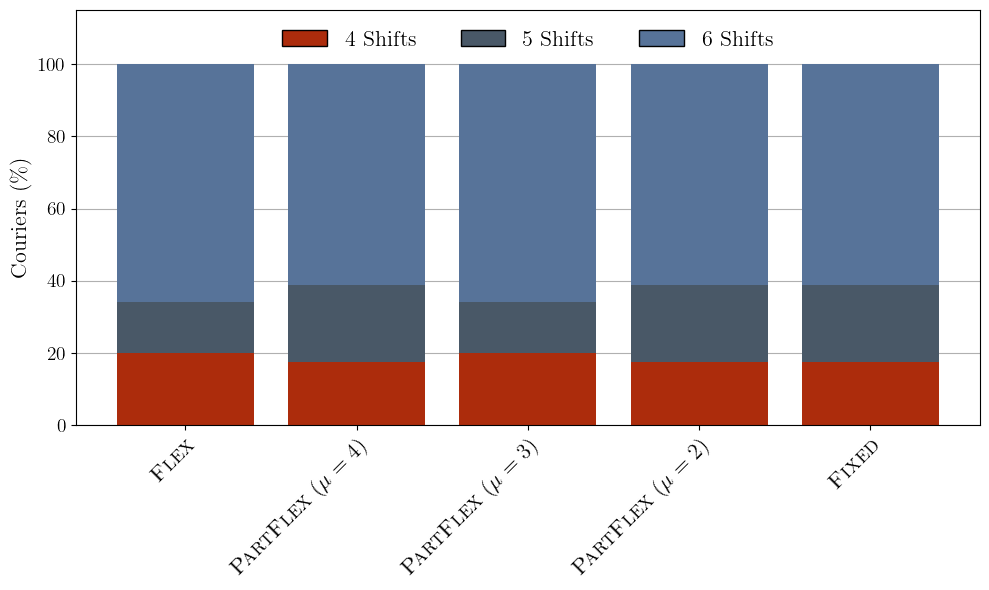

In [24]:
plot_shift_overview()

In [25]:
def plot_shift_overview_db():
  
    db = [0.5, 1.0, 2.0, 4.0]

    fig, ax = plt.subplots(figsize=(10,6))

    data = results_df[results_df['model']!= 'baseline']

    # Barplot

    # Working 48
    ticks = range(len(db))
    working_32_means = data.groupby('demand_baseline', observed=True)['working_32'].mean()
    working_40_means = data.groupby('demand_baseline', observed=True)['working_40'].mean()

    ax.bar(
        x=ticks,
        height=working_32_means,
        color=f"C{0}" ,
        linewidth=2,
        edgecolor=None
    )

    ax.bar(
        x=ticks,
        height=working_40_means,
        bottom=working_32_means,
        color=f"C{2}" ,
        linewidth=2,
        edgecolor=None
    )

    ax.bar(
        x=ticks,
        height=100 - working_32_means - working_40_means,
        bottom=working_32_means + working_40_means,
        color=f"C{3}" ,
        linewidth=2,
        edgecolor=None
    )



    ax.set_ylim((0, 115))
    ax.set_xticks(ticks)
    ax.set_xticklabels(db)
    ax.set_ylabel('Couriers (\\%)', fontsize=16)
    ax.yaxis.grid(which='major')
    ax.axes.set_axisbelow(True)
    ax.set_xlabel('')

    ax.legend(handles=[
        Patch(facecolor=f'C{0}', edgecolor='black', label='4 Shifts'),
        Patch(facecolor=f'C{2}', edgecolor='black', label='5 Shifts'),
        Patch(facecolor=f'C{3}', edgecolor='black', label='6 Shifts'),
    ], loc='upper center', ncols=3, frameon=False, fontsize=16)


    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(db, fontsize=16)
    ax.set_xlabel('\\texttt{DB}', fontsize=16)

    for tl in ax.get_xticklabels():
        tl.set_rotation_mode('anchor')
        tl.set_rotation(45)
        tl.set_ha('right')
    for tl in ax.get_yticklabels():
        tl.set_fontsize(14)

    fig.tight_layout()
    fig.savefig('figures/shift_overview_by_db.pdf', dpi=96, bbox_inches='tight')

    return fig, ax

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='\\texttt{DB}', ylabel='Couriers (\\%)'>)

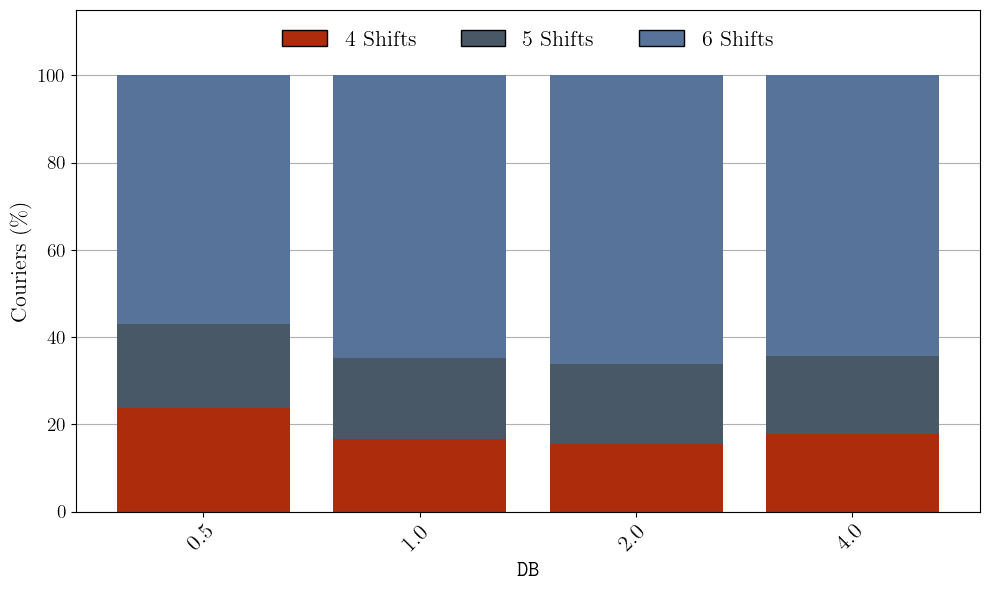

In [26]:
plot_shift_overview_db()